In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from manage import (
    logging,
    TRAINING_DATA_FILE,
    TRAINING_LOSSES_PLOT,
    MUTATION_SCORES_FILE,
    EMBEDDINGS_MUT_FILE,
    EMBEDDINGS_SEQ_FILE,
    Fixynergy,
    MutationDataset,
)

use_cuda = torch.cuda.is_available()
# use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
logging.info(f"Using device {device}")

n_factors = 10

batch_size = 128
shuffle = True
learning_rate = 1e-3
weight_decay = 1e-5
n_epochs = 1000


[2022-01-11 03:17:00 PM]: Using device cuda:0


In [2]:
logging.info("Load data...")
seq_mut: pd.DataFrame = pd.read_feather(TRAINING_DATA_FILE)
training_data = MutationDataset(seq_mut)

model = Fixynergy(
    n_seqs=training_data.n_seqs,
    n_muts=training_data.n_muts,
    n_factors=n_factors
)
model.to(device)
loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)


[2022-01-11 03:17:00 PM]: Load data...
[2022-01-11 03:17:02 PM]: 6319 seqs and 2984 muts
[2022-01-11 03:17:02 PM]: 11756 1s and 9942868 0s


[2022-01-11 03:17:03 PM]: Start training
[2022-01-11 03:17:04 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:05 PM]: 1/1000, loss: 19.309110641479492
[2022-01-11 03:17:05 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:06 PM]: 2/1000, loss: 16.52993392944336
[2022-01-11 03:17:06 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:07 PM]: 3/1000, loss: 18.51520538330078
[2022-01-11 03:17:07 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:08 PM]: 4/1000, loss: 12.552238464355469
[2022-01-11 03:17:08 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:09 PM]: 5/1000, loss: 10.95047378540039
[2022-01-11 03:17:09 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:10 PM]: 6/1000, loss: 9.645429611206055
[2022-01-11 03:17:10 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:11 PM]: 7/1000, loss: 9.431872367858887
[2022-01-11 03:17:11 PM]: 9931112 dropped, 23512 remaining
[2022-01-11 03:17:12 PM]: 8/1000, loss: 9.512569427490234
[2022-01-11 03:17:12 

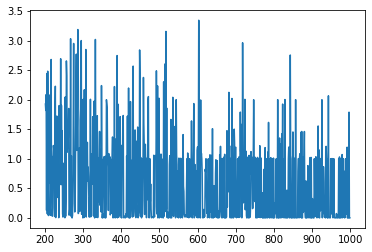

In [3]:
logging.info("Start training")

model.train()

losses = []
seq_ids: torch.Tensor
mut_ids: torch.Tensor
targets: torch.Tensor
pred: torch.Tensor
loss: torch.Tensor
for epoch in range(n_epochs):
    training_data.balance_values()
    for (seq_ids, mut_ids), targets in DataLoader(
        training_data,
        batch_size=batch_size,
        shuffle=shuffle
    ):
        seq_ids = seq_ids.to(device)
        mut_ids = mut_ids.to(device)

        pred = model(seq_ids, mut_ids)
        target = targets.to(device)
        target = target.float().view(pred.size())
        loss: torch.Tensor = loss_fn(pred, target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    logging.info(f"{epoch + 1}/{n_epochs}, loss: {loss.item()}")
    losses.append({
        "epoch": epoch,
        "loss": loss.item()
    })

losses = pd.DataFrame.from_records(losses, index="epoch")
losses = losses[losses.index > n_epochs * 0.2]
plt.plot(losses["loss"])
plt.savefig(TRAINING_LOSSES_PLOT)
logging.info(f"{TRAINING_LOSSES_PLOT} saved!")


In [9]:
logging.info("Mutation score matrix")

model.eval()

n_muts = len(training_data.mut_id2name)
n_seqs = len(training_data.seq_id2name)
mutation_scores = np.zeros((n_seqs, n_muts))
with torch.no_grad():
    for seq_id in training_data.seq_id2name.index:
        seq_ids = torch.Tensor(np.full(n_muts, seq_id)).int().to(device)
        mut_ids = torch.Tensor(training_data.mut_id2name.index).int().to(device)
        pred: torch.Tensor = model(seq_ids, mut_ids)
        (pred, ) = pred.data.cpu().numpy().T
        mutation_scores[seq_id, :] = pred

mutation_scores = pd.DataFrame(
    mutation_scores,
    index=training_data.seq_id2name.values,
    columns=training_data.mut_id2name.values
)

mutation_scores.to_csv(MUTATION_SCORES_FILE)
logging.info(f"{MUTATION_SCORES_FILE} saved!")


[2022-01-11 05:07:46 PM]: Mutation score matrix
[2022-01-11 05:08:09 PM]: Output/mutation_scores.csv saved!


In [12]:
mut_embbedings = model.mut_embedding.weight.data.cpu().numpy()
mut_embbedings = pd.DataFrame(
    mut_embbedings,
    columns=[f"comb_{n}" for n in range(model.n_factors)],
    index=training_data.mut_id2name
)
mut_embbedings.to_csv(EMBEDDINGS_MUT_FILE)
logging.info(f"{EMBEDDINGS_MUT_FILE} saved!")

seq_embbedings = model.seq_embedding.weight.data.cpu().numpy()
seq_embbedings = pd.DataFrame(
    seq_embbedings,
    columns=[f"comb_{n}" for n in range(model.n_factors)],
    index=training_data.seq_id2name
)
seq_embbedings.to_csv(EMBEDDINGS_SEQ_FILE)
logging.info(f"{EMBEDDINGS_SEQ_FILE} saved!")

# mutation_scores_2 = seq_embbedings.dot(mut_embbedings.T)
# mutation_scores_2.to_csv(MUTATION_SCORES_2_FILE)
# logging.info(f"{MUTATION_SCORES_2_FILE} saved!")


[2022-01-11 05:08:51 PM]: Output/embeddings_mut.csv saved!
[2022-01-11 05:08:51 PM]: Output/embeddings_seq.csv saved!
